In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from scipy import spatial
from matplotlib import cm

In [2]:
def load_flights(flight_folder):

    hierarchical_order_list = ["A","B","D","J","H","C","I","L","G"] 

    for flight_file in os.walk("../data/pigeonflocks_trajectories/"+ flight_folder + "/"):
        path_list = flight_file[2]
    

    features_list = pd.DataFrame(columns=["#t(centisec)"])
    accelerations_list = pd.DataFrame(columns=["#t(centisec)"])

    for flight in path_list:    
        full_path = "../data/pigeonflocks_trajectories/" +flight_folder+ "/" + flight
        data_out = pd.read_csv(full_path, delimiter="\t",skiprows=18)
        data_out = data_out.drop("GPS signal",axis = 1)

        # get these limits automcatically for each folder.. where we have all birds... 

        # turn df into the format : time, features, acceleration 
        #time, [x,y,z,dx,dy,dx,H], [ddx,ddy,ddz]
        if data_out.isna().values.any():
            print(flight_folder,flight,"this bird is bad")
            # break #this bird has nans in its track... 
        else: 
            
            bird_id = flight[-5:-4]
            if bird_id not in hierarchical_order_list:
                # Ignore birds that never flew with others/ were not in the full hierarchical analysis
                pass 
            elif len(features_list.columns) <=6: # Fist nieve way to sample so we always have 6 birds in each sub-dataset

                H = hierarchical_order_list.index(bird_id)# lower is better...
                data_out["H"]  = H * len(data_out)
                data_out["H2"]  = H * len(data_out)

                data_out[bird_id+'_features']= data_out[["X(m)","Y(m)", "Z(m)","dX/dt(m/s)","dY/dt(m/s)","dZ/dt(m/s)","H","H2"]].values.tolist()
                data_out[bird_id+'_accelerations'] = data_out[["d^2X/dt^2(m/s^2)","d^2Y/dt^2(m/s^2)","d^2Z/dt^2(m/s^2)"]].values.tolist()

                features_list = features_list.merge(data_out[[bird_id+'_features',"#t(centisec)"]],how="outer",on=["#t(centisec)"])
                accelerations_list = accelerations_list.merge(data_out[[bird_id+'_accelerations',"#t(centisec)"]],how="outer",on=["#t(centisec)"])
        
    
    features_list = features_list.drop("#t(centisec)",axis = 1)
    accelerations_list = accelerations_list.drop("#t(centisec)",axis = 1)

    features_list = features_list.dropna()
    accelerations_list = accelerations_list.dropna()

    return features_list,accelerations_list



In [3]:
# Now repete this process for all the flights to make alist of cleaned flights..
all_features_list = np.zeros((0,500,6,8))
all_accelerations_list = np.zeros((0,500,6,3))

for i in range(2,16):
    try: 
        flight_no = 'ff' + str(i)
        features_list,accelerations_list = load_flights(flight_no)
        
        features_list = features_list.applymap(lambda x: np.array(x))
        accelerations_list = accelerations_list.applymap(lambda x: np.array(x))

        # print(features_list.isna().values.any())
        # print(accelerations_list.isna().values.any())
        # here we somehow create nans?...here!!!! 

        features_list = np.array(features_list.to_numpy().tolist())
        accelerations_list = np.array(accelerations_list.to_numpy().tolist())

        # create sets reshaped 
        # make number of frames a multiple of 500.
        n = int(np.floor(features_list.shape[0]/500))

        features_list = features_list[0:(500*n),:,:]
        accelerations_list = accelerations_list[0:(500*n),:,:]

        print(features_list.shape)
        print(accelerations_list.shape)

        features_list = features_list.reshape((n,500,6,8))
        accelerations_list = accelerations_list.reshape((n,500,6,3))
        # now join to full dataset. 
        all_features_list = np.concatenate((all_features_list,features_list),axis=0)
        all_accelerations_list = np.concatenate((all_accelerations_list,accelerations_list),axis=0)

    except:
        pass
    # break

# print(np.count_nonzero(~np.isnan(all_features_list))) #still nans?.... 
# print(np.count_nonzero(~np.isnan(all_accelerations_list)))



ff2 ff2_B.txt this bird is bad
ff2 ff2_J.txt this bird is bad
(19000, 6, 8)
(19000, 6, 3)
(21500, 6, 8)
(21500, 6, 3)
ff4 ff4_J.txt this bird is bad
(8000, 6, 8)
(8000, 6, 3)
ff5 ff5_B.txt this bird is bad
(20500, 6, 8)
(20500, 6, 3)
ff6 ff6_I.txt this bird is bad
ff6 ff6_C.txt this bird is bad
ff6 ff6_L.txt this bird is bad
(16500, 3, 8)
(16500, 3, 3)
ff7 ff7_I.txt this bird is bad
ff7 ff7_J.txt this bird is bad
(11500, 6, 8)
(11500, 6, 3)
(7000, 6, 8)
(7000, 6, 3)
(12000, 6, 8)
(12000, 6, 3)
ff10 ff10_M.txt this bird is bad
ff10 ff10_D.txt this bird is bad
(12000, 6, 8)
(12000, 6, 3)
(1500, 6, 8)
(1500, 6, 3)
(7500, 6, 8)
(7500, 6, 3)
(9000, 6, 8)
(9000, 6, 3)
(5500, 6, 8)
(5500, 6, 3)
(5000, 6, 8)
(5000, 6, 3)


In [4]:

# --- Centering and scaling each simulation ---
for i in range(all_features_list.shape[0]):
    # xcenter in x y and z..  get the mean xyz of all the birds of all the frames. 
    x_frame_center = np.mean(all_features_list[i,:,:,0]) # x frame center  
    y_frame_center = np.mean(all_features_list[i,:,:,1]) # y frame center  
    z_frame_center = np.mean(all_features_list[i,:,:,2]) # z frame center  

    all_features_list[i,:,:,0] = all_features_list[i,:,:,0] - x_frame_center
    all_features_list[i,:,:,1] = all_features_list[i,:,:,1] - y_frame_center
    all_features_list[i,:,:,2] = all_features_list[i,:,:,2] - z_frame_center

    # # scale all dimentions by the same value to keep symetries. 
    max_variance_dim = np.max(np.array([np.max(all_features_list[i,:,:,0]),np.max(all_features_list[i,:,:,0]),np.max(all_features_list[i,:,:,0])]))

    all_features_list[i,:,:,0] = all_features_list[i,:,:,0]/max_variance_dim
    all_features_list[i,:,:,1] = all_features_list[i,:,:,1]/max_variance_dim
    all_features_list[i,:,:,2] = all_features_list[i,:,:,2]/max_variance_dim
    # This however does affect global valocity... keep in mind... 

    # scale the y acceleration values.. is this scaling legit?... 
    all_accelerations_list[i,:,:,:] = all_accelerations_list[i,:,:,:]/np.max(all_accelerations_list[i,:,:,:])

# center the birds to zero and standard scalar the values


# cleaning out the non-collective motions flight videos where x accelerations are non corrolated between the birds.
corrolation_threshold = 0.3
print(all_accelerations_list.shape)
badvids = 0
badvids_id = []
for i in range(all_accelerations_list.shape[0]):
    video_accelerations = all_accelerations_list[i,:,:,0]
    mean_accels = np.mean(video_accelerations,axis=1)
    if np.max(np.abs(mean_accels)) < corrolation_threshold:
        badvids = badvids + 1
        badvids_id.append(i)

badvids_id = np.array(badvids_id)

all_accelerations_list = np.delete(all_accelerations_list,badvids_id,axis=0)
all_features_list = np.delete(all_features_list,badvids_id,axis=0)

print(badvids, "bad uncorrolated videos") #half of the dieos are not good! 
print(all_accelerations_list.shape)
print(all_accelerations_list.shape)


np.save('flight_feats.npy',all_features_list)
np.save('flight_acells.npy',all_accelerations_list)

(280, 500, 6, 3)
185 bad uncorrolated videos
(95, 500, 6, 3)
(95, 500, 6, 3)


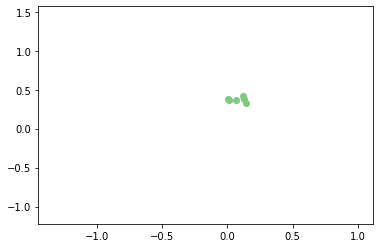

In [10]:
view_features = all_features_list[5,:,:,:]

fig = plt.figure()
camera = Camera(fig)
colors = cm.get_cmap('Accent')

for j in range(view_features.shape[0]):
    
    plt.scatter(view_features[j,:,0],view_features[j,:,1],color=colors(0))
    camera.snap()

from IPython.display import HTML
HTML(camera.animate().to_jshtml())
# now re-shape into numpy array format for the GNN! 

animation = camera.animate()
animation.save('../animations/flight_5.gif',fps=50)

(500, 6)


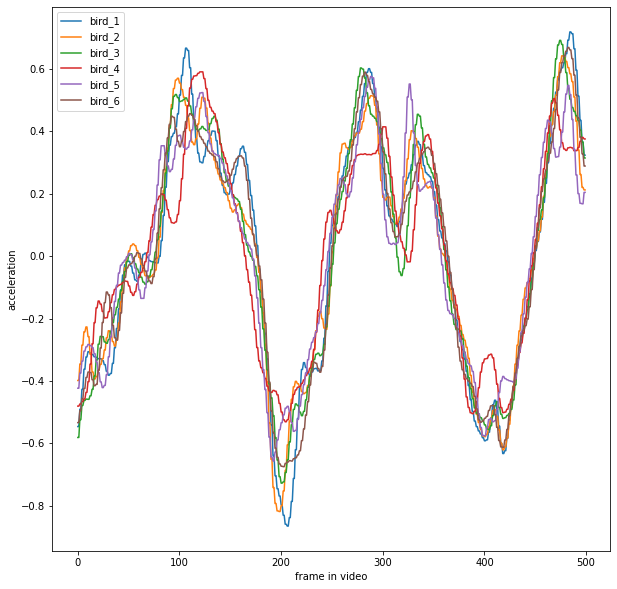

In [ ]:
# Explore variation of velocities and alignement between the movies generated from the flights.


video_accelerations = all_accelerations_list[4,:,:,0]
print(video_accelerations.shape)

fig = plt.figure(figsize=(10,10))

for bird in range(6):
    plt.plot(range(0,500),video_accelerations[:,bird],label="bird_"+str(bird+1))
plt.ylabel("acceleration")
plt.xlabel("frame in video")
plt.legend()
plt.show()

# plot some videos with collective motion and some videos without... have a way to classify these and onl take the collective motion ones... 

# classify by correletion between acceleations.?  

    # keep video as birds are collectively moving.. 

# plt.scatter(range(0,500),mean_accels)
# plt.ylim([-1,1])

# some statistic to descibe these kinds of motions... overlap between the birds?... alignment?... 